# Project Scope:

There are 3 groups (control, active neural mobilizations, and passive neural mobilizations). The groups were then split into those individuals who had an elbow extension "EE" range of motion below and above the entire sample sizes average. A pre-grip and post-grip strength sample was taken for all subjects.

Group A (control): A1 & A2

Group B (active): B1 & B2

Group C (passive): C1 & C2

where "1" is the group with "tighter" elbows and "2" is the group with "more flexible" elbows.

Two main questions of this study were:

1. Is there a difference when comparing the passive and/or active neural mobs groups to the control?
2. Is there a difference specifically when looking at those who had elbow extension ranges of motion less than or greater than the collective average?

First, we upload raw data:

In [1]:
Data_f = read.csv(file="Exercise_stats.csv",sep=",",header=T)

Then upload libraries that will be used during analysis:

In [12]:
library(tidyverse)
library(ggpubr) 
library(emmeans)
library(rstatix)


Attaching package: ‘rstatix’


The following object is masked from ‘package:stats’:

    filter




# Summary Statistics

Summarizing 3 test groups:

In [10]:
Data_f %>% 
  group_by(Group) %>%
  summarize(mean = mean(Strength_Differences), n = n())

Group,mean,n
<chr>,<dbl>,<int>
Active,-3.529412,17
Control,-1.764706,17
Passive,-2.437500,16


Summarizing 3 test groups and their subgroups:

In [14]:
Data_f %>% 
  group_by(Group, EE_average) %>%
  summarize(mean = mean(Strength_Differences), n = n())

`summarise()` has grouped output by 'Group'. You can override using the
`.groups` argument.


Group,EE_average,mean,n
<chr>,<chr>,<dbl>,<int>
Active,Above,-6.1000000,10
Active,Below,0.1428571,7
Control,Above,-2.6666667,6
Control,Below,-1.2727273,11
Passive,Above,-3.5000000,8
Passive,Below,-1.3750000,8


# What is ANOVA?

The ANOVA (Analysis of Variance) is a popular statistical analysis test. The idea behind the ANOVA test: if the average variation between groups is large enough compared to the average variation within groups, then you can conclude that at least one group mean is not equal to the others. To analyze that we evaluate whether the differences between the group means are significant by comparing the two variance estimates. 

The ANOVA has a several assumptions that need to be fulfilled: 
1) Sample independence – that each sample has been drawn randomly and independently of the other samples 
2) Normality - each sample is taken from a normally distributed population 
3) Variance equality – variance of data in the different groups should be the same (homogeneity of variances, homoscedasticity)

The ANOVA is also sensitive to outliers.

# Data Analysis: One-Way ANOVA

One-way ANOVA - test where the data are organized into several groups according to only one single grouping variable (e.g. test group).

## TEST A: Grouping data by test groups (Control, Active, Passive)

**Are means of Control, Active, Passive groups significantly different?** 

Re-order groups:

In [16]:
Data_f = Data_f %>% reorder_levels(Group, order = c("Control", "Active", "Passive"))

Run summary statistics again using function from '*rstatix*' package:

In [17]:
Data_f %>% group_by(Group) %>% get_summary_stats(Strength_Differences, type = "mean_sd")

Group,variable,n,mean,sd
<fct>,<fct>,<dbl>,<dbl>,<dbl>
Control,Strength_Differences,17,-1.765,7.198
Active,Strength_Differences,17,-3.529,5.843
Passive,Strength_Differences,16,-2.438,5.573


## Initial Analysis

**Checking if ANOVA assumptions are met:**

Identifying outliers:

In [13]:
Data_f %>% 
  group_by(Group) %>% 
  identify_outliers(Strength_Differences)

Group,EE_average,Range_of_Motion,Pre_Strength,Post_Strength,Strength_Differences,is.outlier,is.extreme
<chr>,<chr>,<int>,<int>,<int>,<int>,<lgl>,<lgl>


There are no outliers.

Checking normality assumptions by group:

In [18]:
Data_f %>% group_by(Group) %>% shapiro_test(Strength_Differences)

Group,variable,statistic,p
<fct>,<chr>,<dbl>,<dbl>
Control,Strength_Differences,0.9650339,0.7270752
Active,Strength_Differences,0.9235936,0.1698376
Passive,Strength_Differences,0.9767930,0.9330254


The strength differences were normally distributed (p > 0.05) for each group, as assessed by Shapiro_Wilk's test 
for normality.

Homogeneity of variance assumption:

In [19]:
Data_f %>% levene_test(Strength_Differences ~ Group)

df1,df2,statistic,p
<int>,<int>,<dbl>,<dbl>
2,47,0.5090151,0.6043627


Since p>0.05, there is no significant difference between variances across groups. 

Normal QQ plot to visualize normality. QQ plot draws the correlation between a given data and the normality 
distribution.

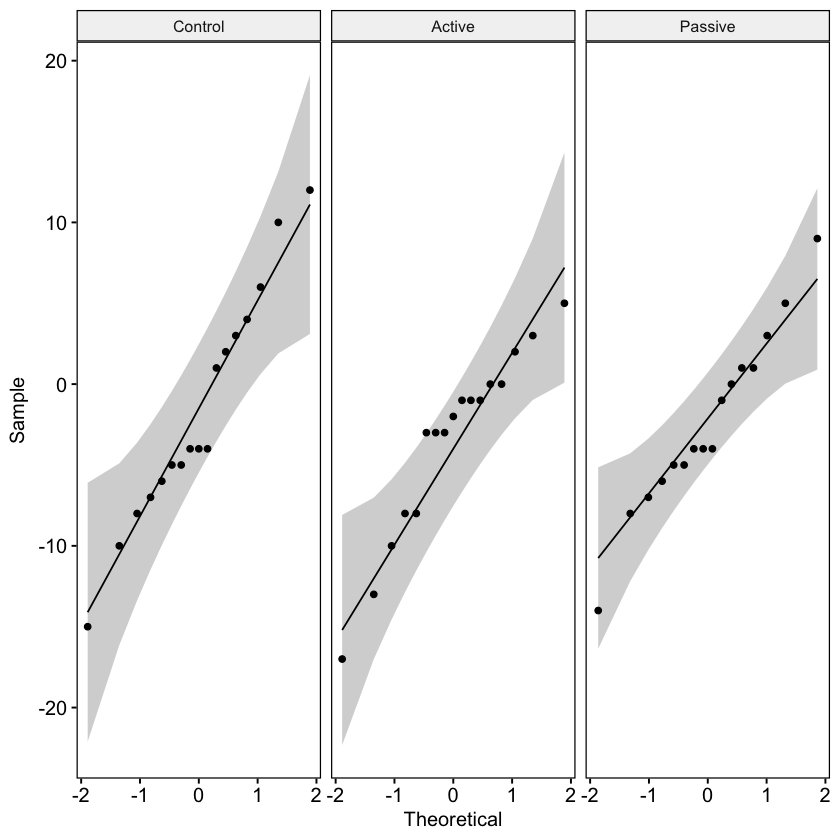

In [20]:
ggqqplot(Data_f, "Strength_Differences", facet.by = "Group")

All the points fall approximately along the reference line for each cell. So we can assume 
normality of the data.

## ANOVA Computation

Comparing the mean of multiple groups using ANOVA test:

In [22]:
aov_test = Data_f %>% anova_test(Strength_Differences ~ Group)
# Print results
aov_test

,Effect,DFn,DFd,F,p,p<.05,ges
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
1,Group,2,47,0.344,0.711,,0.014


ANOVA test results indicate that there are no significant differences between groups (since p=0.711).
Also, F value (F<1) indicates that there are no significant differences between the means of the sample groups.

A significant one-way ANOVA is generally followed up by Tukey post-hoc tests to perform 
multiple pairwise comparison between groups:

In [23]:
pairwise_tukey = Data_f %>% tukey_hsd(Strength_Differences ~ Group)
pairwise_tukey

,term,group1,group2,null.value,estimate,conf.low,conf.high,p.adj,p.adj.signif
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,Group,Control,Active,0,-1.7647059,-6.960274,3.430862,0.691,ns
2,Group,Control,Passive,0,-0.6727941,-5.948918,4.603330,0.949,ns
3,Group,Active,Passive,0,1.0919118,-4.184212,6.368036,0.871,ns


A different method to perform pairwise comparison:

In [24]:
pairwise_t = Data_f %>% pairwise_t_test(Strength_Differences ~ Group, p.adjust.method = "bonferroni")
pairwise_t 

,.y.,group1,group2,n1,n2,p,p.signif,p.adj,p.adj.signif
,<chr>,<chr>,<chr>,<int>,<int>,<dbl>,<chr>,<dbl>,<chr>
1,Strength_Differences,Control,Active,17,17,0.415,ns,1,ns
2,Strength_Differences,Control,Passive,17,16,0.759,ns,1,ns
3,Strength_Differences,Active,Passive,17,16,0.619,ns,1,ns


All p-values are above 0.05, therefore we can conclude that there are no significant differences
among any of the groups (both pairwise tests agree).

## Visualization

Creating a box plot of strength differences by group:

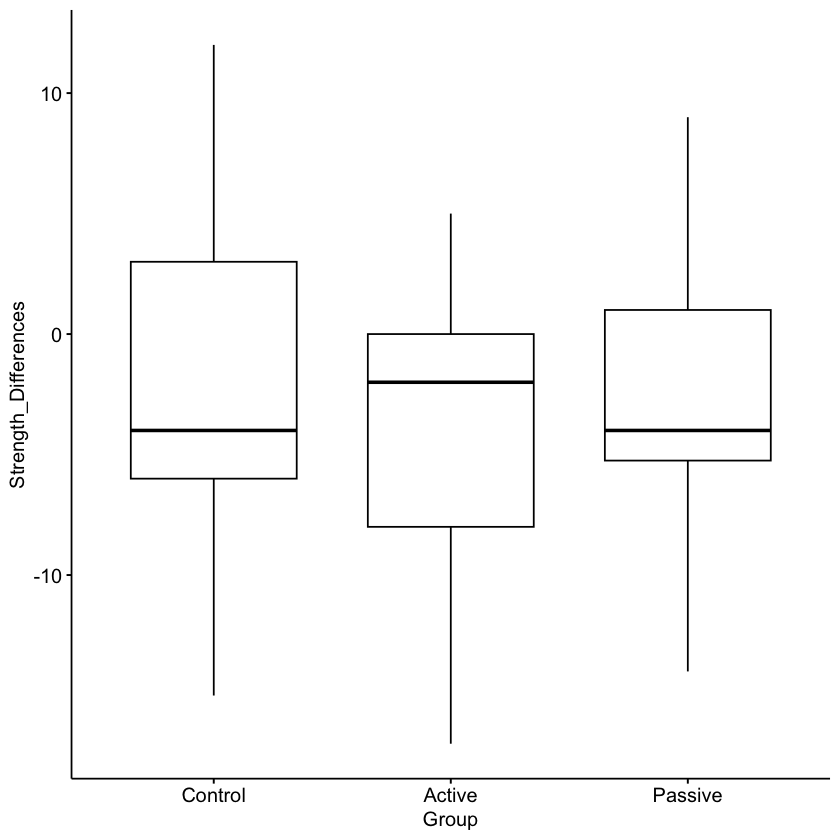

In [25]:
ggboxplot(Data_f, x = "Group", y = "Strength_Differences")

Visualization: box plots with p-values (show adjusted p-values)

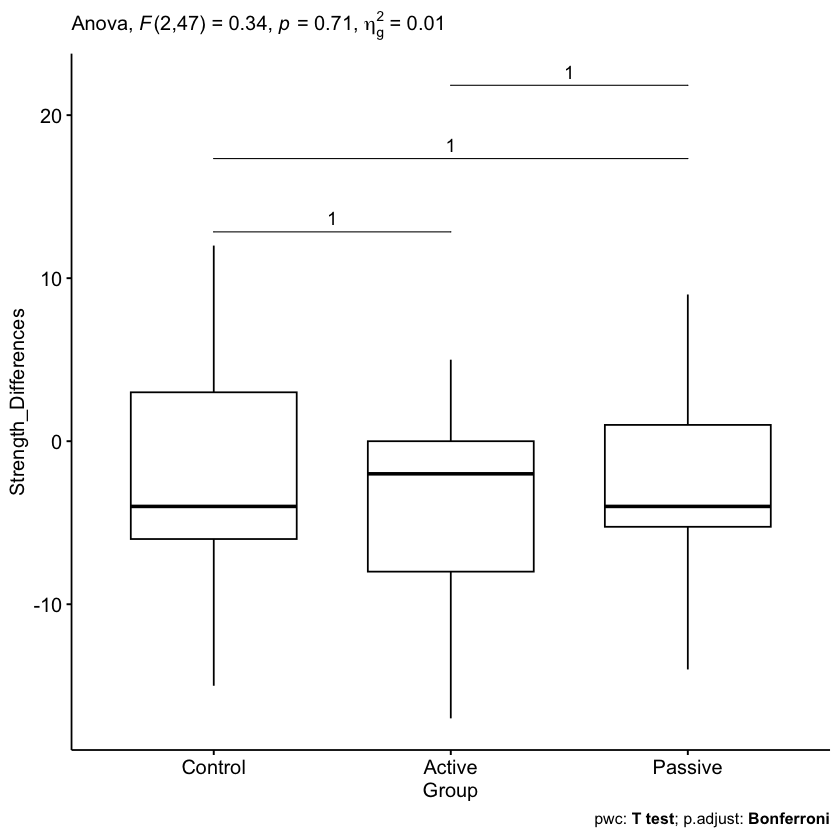

In [26]:
pairwise_t = pairwise_t %>% add_xy_position(x = "Group")
ggboxplot(Data_f, x = "Group", y = "Strength_Differences") +
  stat_pvalue_manual(pairwise_t, label = "p.adj", tip.length = 0, step.increase = 0.1) +
  labs(subtitle = get_test_label(aov_test, detailed = TRUE), caption = get_pwc_label(pairwise_t))

Show significance levels, hide non-significant test:

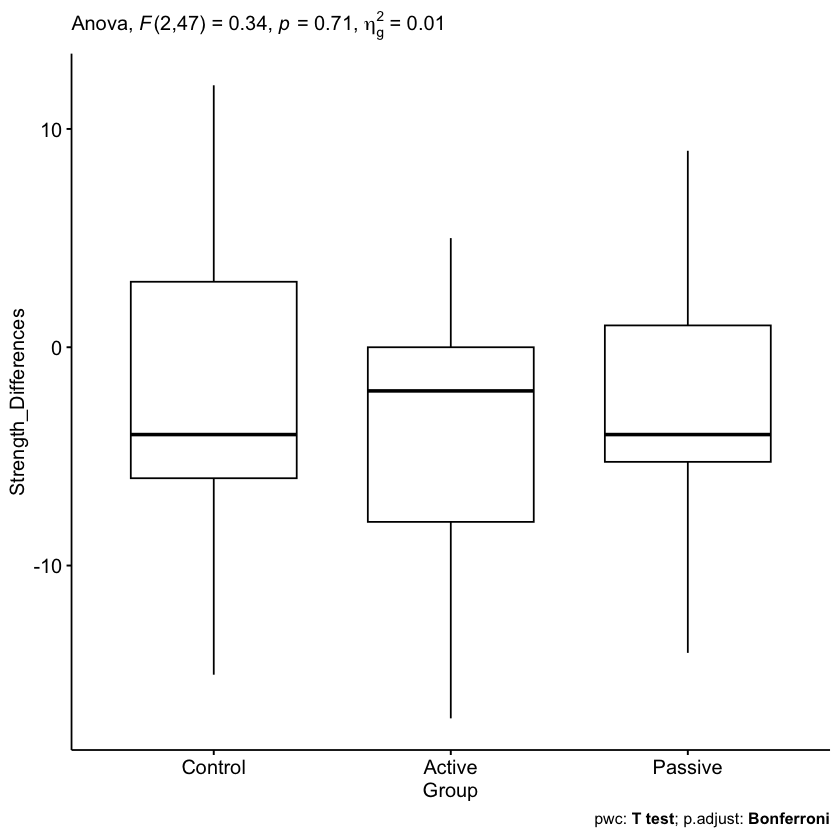

In [27]:
ggboxplot(Data_f, x = "Group", y = "Strength_Differences") +
  stat_pvalue_manual(pairwise_t, hide.ns = TRUE, label = "p.adj.signif") +
  labs(subtitle = get_test_label(aov_test, detailed = TRUE), caption = get_pwc_label(pairwise_t))

## TEST B: Grouping data by EE_average (Above, Below)
**Are 'Above' and 'Below' EE_average group means significantly different?**

Summary statistics:

In [28]:
Data_f %>% group_by(EE_average) %>% get_summary_stats(Strength_Differences, type = "mean_sd")

EE_average,variable,n,mean,sd
<chr>,<fct>,<dbl>,<dbl>,<dbl>
Above,Strength_Differences,24,-4.375,5.747
Below,Strength_Differences,26,-0.923,6.196


## Initial Analysis
**Checking if ANOVA assumptions are met:**

Identifying outliers:

In [29]:
Data_f %>% group_by(EE_average) %>% identify_outliers(Strength_Differences)

EE_average,Group,Range_of_Motion,Pre_Strength,Post_Strength,Strength_Differences,is.outlier,is.extreme
<chr>,<fct>,<int>,<int>,<int>,<int>,<lgl>,<lgl>
Above,Control,55,82,72,10,TRUE,FALSE
Above,Active,78,101,118,-17,TRUE,FALSE


There are two outliers - one in control group, one in active.

Checking normality assumptions by EE_average group:

In [30]:
Data_f %>% group_by(EE_average) %>% shapiro_test(Strength_Differences)

EE_average,variable,statistic,p
<chr>,<chr>,<dbl>,<dbl>
Above,Strength_Differences,0.964849,0.5432093
Below,Strength_Differences,0.992435,0.9991479


The strength differences were normally distributed (p > 0.05) for each EE_average group, as assessed by
Shapiro_Wilk's test for normality.

Homogeneity of variance assumption:

In [31]:
Data_f %>% levene_test(Strength_Differences ~ EE_average)

Warning message in leveneTest.default(y = y, group = group, ...):
“group coerced to factor.”


df1,df2,statistic,p
<int>,<int>,<dbl>,<dbl>
1,48,0.8026163,0.3747833


Since p>0.05, there is no significant variance differences across groups.

Normal QQ plot to visualize normality. QQ plot draws the correlation between a given data and the normality distribution.

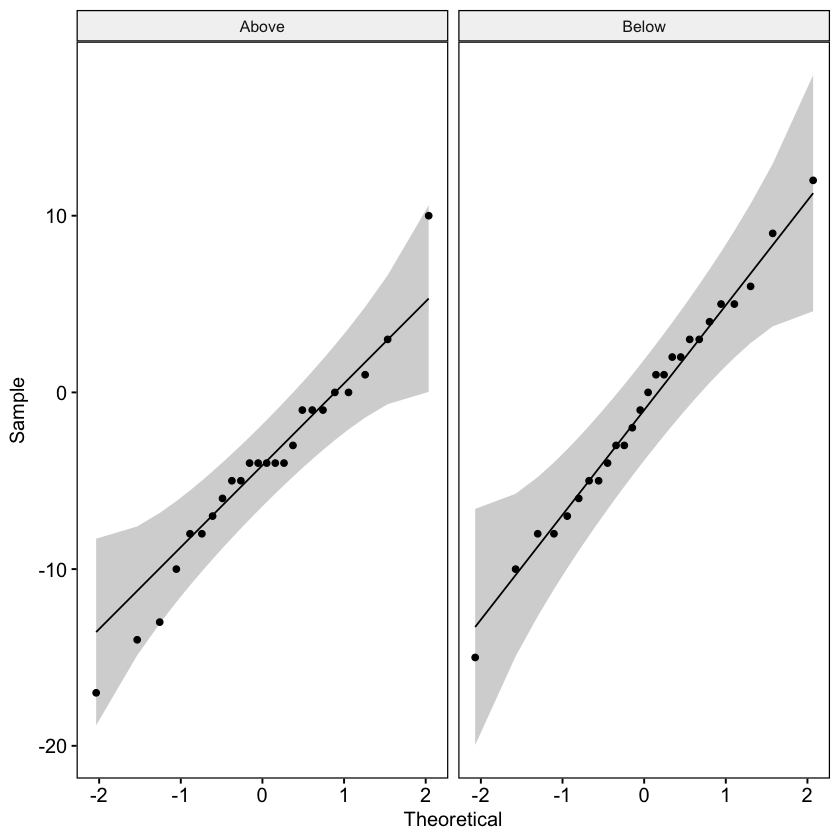

In [32]:
ggqqplot(Data_f, "Strength_Differences", facet.by = "EE_average")

All the points fall approximately along the reference line for each cell. So we can assume normality of the data.

## ANOVA Computation

Compare the mean of multiple groups using ANOVA test:

In [33]:
aov_test3 = Data_f %>% anova_test(Strength_Differences ~ EE_average)
aov_test3

,Effect,DFn,DFd,F,p,p<.05,ges
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
1,EE_average,1,48,4.151,0.047,*,0.08


There are statistically significant differences between EE_average groups (p<0.05).

Pairwise comparison (2 methods):

In [34]:
pairwise_tukey3 = Data_f %>% tukey_hsd(Strength_Differences ~ EE_average)
pairwise_tukey3

,term,group1,group2,null.value,estimate,conf.low,conf.high,p.adj,p.adj.signif
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,EE_average,Above,Below,0,3.451923,0.04546756,6.858379,0.0471,*


In [35]:
pairwise_t3 = Data_f %>% pairwise_t_test(Strength_Differences ~ EE_average, p.adjust.method = "bonferroni")
pairwise_t3 

,.y.,group1,group2,n1,n2,p,p.signif,p.adj,p.adj.signif
,<chr>,<chr>,<chr>,<int>,<int>,<dbl>,<chr>,<dbl>,<chr>
1,Strength_Differences,Above,Below,24,26,0.0471,*,0.0471,*


Both pairwise tests show that differences were statistically significant (p < 0.05) between EE_average groups.

## Visualization

Creating a box plot of strength differences by EE_average group:

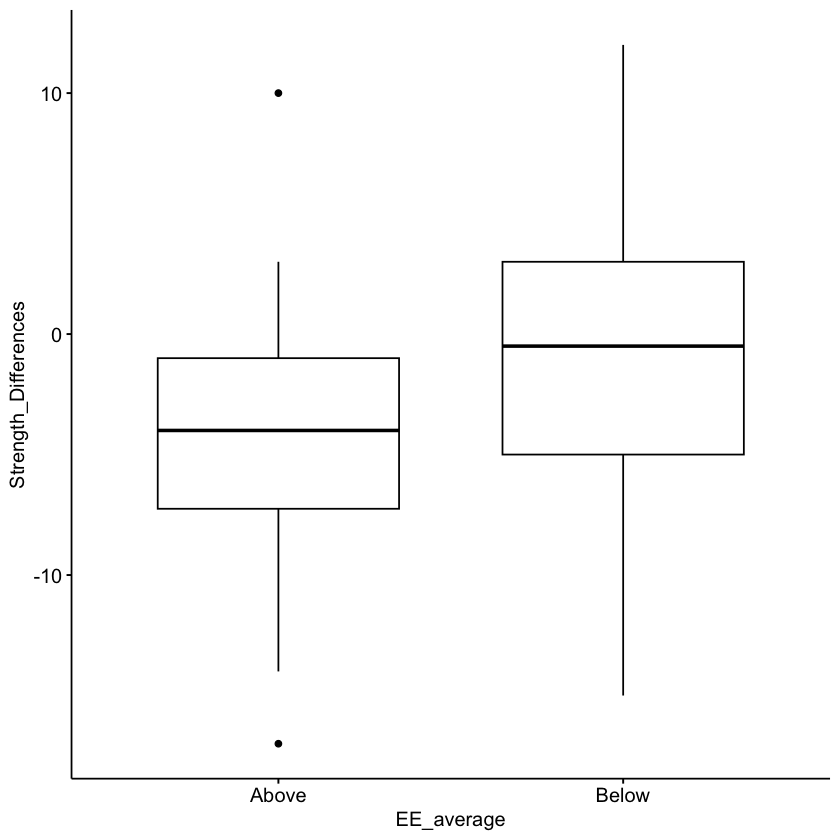

In [36]:
ggboxplot(Data_f, x = "EE_average", y = "Strength_Differences")

Visualization: box plots with p-values (show adjusted p-values)

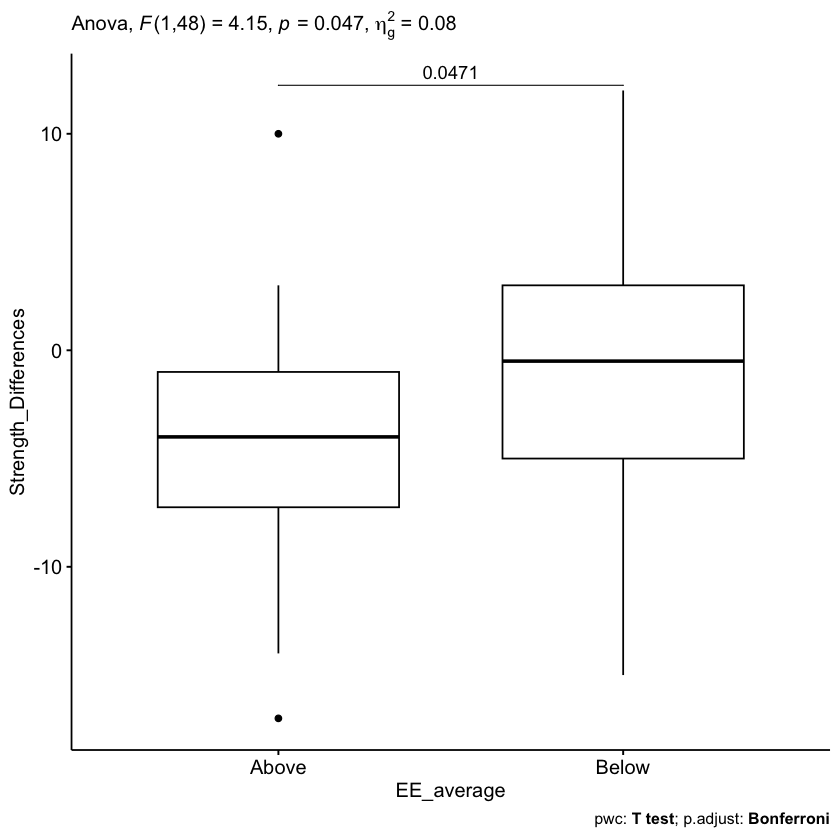

In [37]:
pairwise_t3 = pairwise_t3 %>% add_xy_position(x = "EE_average")
ggboxplot(Data_f, x = "EE_average", y = "Strength_Differences") +
  stat_pvalue_manual(pairwise_t3, label = "p.adj", tip.length = 0, step.increase = 0.1) +
  labs(subtitle = get_test_label(aov_test3, detailed = TRUE), caption = get_pwc_label(pairwise_t3))

Show significance levels, hide non-significant test:

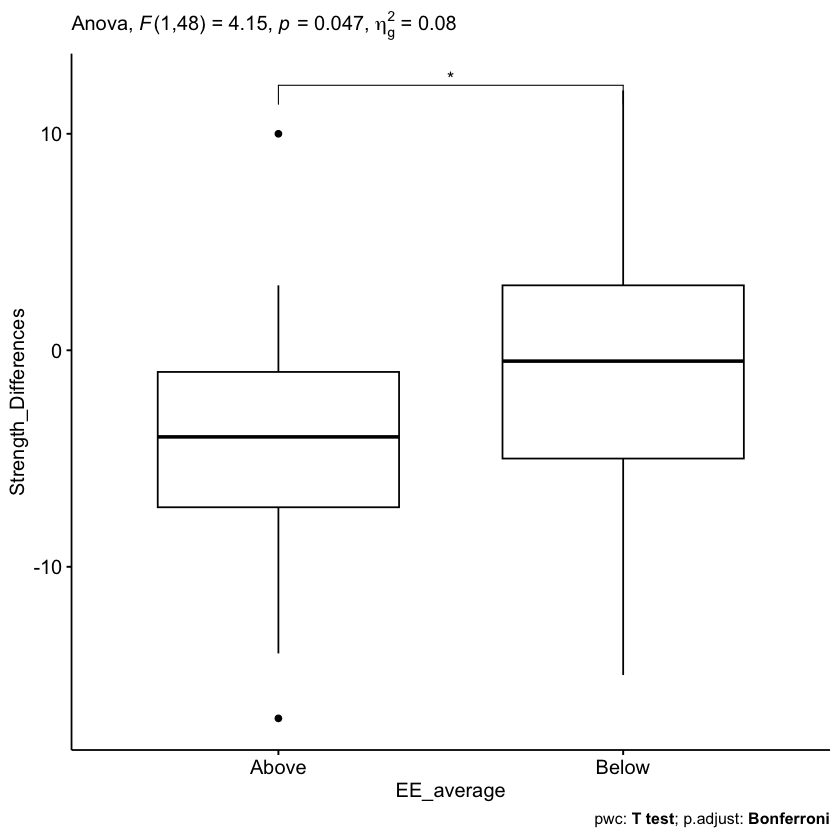

In [38]:
ggboxplot(Data_f, x = "EE_average", y = "Strength_Differences") +
  stat_pvalue_manual(pairwise_t3, hide.ns = TRUE, label = "p.adj.signif") +
  labs(subtitle = get_test_label(aov_test3, detailed = TRUE), caption = get_pwc_label(pairwise_t3))

# TWO-WAY ANOVA

Two-way ANOVA is used to evaluate simultaneously the effect of two different grouping variables on a continuous outcome variable (in this case strength differences).

## TEST C: Analyzing 8 sub-groups

Summary statistics - computing mean and standard deviation by subgroups:

In [39]:
Data_f %>% group_by(Group, EE_average) %>% get_summary_stats(Strength_Differences, type = "mean_sd")

Group,EE_average,variable,n,mean,sd
<fct>,<chr>,<fct>,<dbl>,<dbl>,<dbl>
Control,Above,Strength_Differences,6,-2.667,6.314
Control,Below,Strength_Differences,11,-1.273,7.888
Active,Above,Strength_Differences,10,-6.100,6.008
Active,Below,Strength_Differences,7,0.143,3.185
Passive,Above,Strength_Differences,8,-3.500,5.099
Passive,Below,Strength_Differences,8,-1.375,6.163


## Initial Analysis
**Checking if ANOVA assumptions are met:**

Identifying outliers:

In [40]:
Data_f %>% group_by(Group, EE_average) %>% identify_outliers(Strength_Differences)

Group,EE_average,Range_of_Motion,Pre_Strength,Post_Strength,Strength_Differences,is.outlier,is.extreme
<fct>,<chr>,<int>,<int>,<int>,<int>,<lgl>,<lgl>
Control,Above,55,82,72,10,TRUE,TRUE
Passive,Above,48,106,120,-14,TRUE,FALSE


There are two outliers - one in control above average EE subgroup (extreme outlier) and one in passive above average EE subgroup (non extreme).

Checking if data is normally distributed by subgroup:

In [41]:
Data_f %>% group_by(Group, EE_average) %>% shapiro_test(Strength_Differences)

Group,EE_average,variable,statistic,p
<fct>,<chr>,<chr>,<dbl>,<dbl>
Control,Above,Strength_Differences,0.6727463,0.003150309
Control,Below,Strength_Differences,0.9807008,0.969932898
Active,Above,Strength_Differences,0.8914813,0.176206073
Active,Below,Strength_Differences,0.8919224,0.284842368
Passive,Above,Strength_Differences,0.8874905,0.221736044
Passive,Below,Strength_Differences,0.9141276,0.384047877


One group is not normally distributed - Control Above EE_average (p < 0.05).

Creating QQ plots for each cell of design:

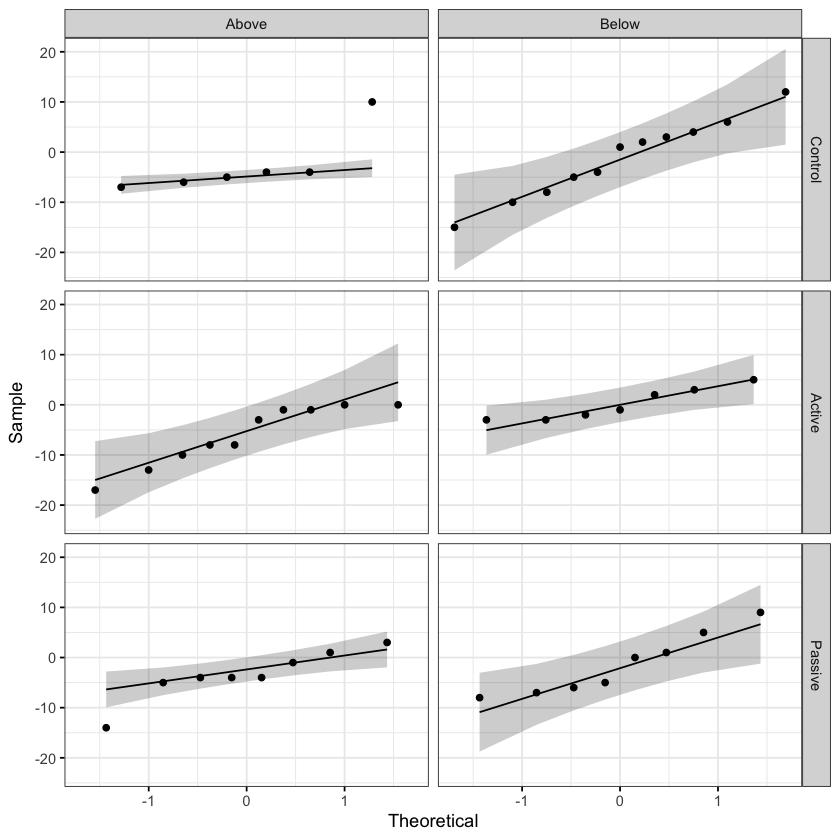

In [42]:
ggqqplot(Data_f, "Strength_Differences", ggtheme = theme_bw()) +
         facet_grid(Group ~ EE_average)

Two outliers identified above do not fall along the reference line. One extreme outlier in Control Above EE_average subgroup is responsible for non-normal data distribution in that subgroup.

Homogeneity of variance assumption:

In [43]:
Data_f %>% levene_test(Strength_Differences ~ Group*EE_average)

df1,df2,statistic,p
<int>,<int>,<dbl>,<dbl>
5,44,1.179521,0.3345548


The Levene's test is not significant (p > 0.05) therefore we can assume the homogeneity of variances in different subgroups.

## ANOVA Computation

Two-way ANOVA test with interaction effect:

In [44]:
aov_test2 = Data_f %>% anova_test(Strength_Differences ~ Group*EE_average)
aov_test2

,Effect,DFn,DFd,F,p,p<.05,ges
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
1,Group,2,44,0.120,0.887,,0.005
2,EE_average,1,44,3.477,0.069,,0.073
3,Group:EE_average,2,44,0.735,0.485,,0.032


There is no statistically significant main effects of  "Group" and "EE_average" on strength differences. Also, interactions between "Group" and "EE_average" are also not significant (p > 0.05).

**1) Investigating the effect of 'EE_average' at every level of 'Group'**

Analyzing simple main effects - group data by 'Group' and fit ANOVA:

In [45]:
model = lm(Strength_Differences ~ Group*EE_average, data = Data_f)
Data_f %>% group_by(Group) %>% anova_test(Strength_Differences ~ EE_average, error = model)

,Group,Effect,DFn,DFd,F,p,p<.05,ges
,<fct>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
1,Control,EE_average,1,44,0.201,0.656,,0.005
2,Active,EE_average,1,44,4.266,0.045,*,0.088
3,Passive,EE_average,1,44,0.480,0.492,,0.011


The simple main effect of "EE_average" on strength differences is statistically significant only in Active group.

Pairwise comparison:

In [46]:
pairwise_t2 = Data_f %>% group_by(Group) %>% emmeans_test(Strength_Differences ~ EE_average, 
                                                          p.adjust.method = "bonferroni")
pairwise_t2

,Group,term,.y.,group1,group2,df,statistic,p,p.adj,p.adj.signif
,<fct>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,Control,EE_average,Strength_Differences,Above,Below,44,-0.4478158,0.65648332,0.65648332,ns
2,Active,EE_average,Strength_Differences,Above,Below,44,-2.0654561,0.04480106,0.04480106,*
3,Passive,EE_average,Strength_Differences,Above,Below,44,-0.6929421,0.49198743,0.49198743,ns


There is a significant difference among EE_average subgroups only in Active group.

Inspecting main effects - pairwise t-test comparison:

In [47]:
Data_f %>% pairwise_t_test(Strength_Differences ~ EE_average, p.adjust.method = "bonferroni")

,.y.,group1,group2,n1,n2,p,p.signif,p.adj,p.adj.signif
,<chr>,<chr>,<chr>,<int>,<int>,<dbl>,<chr>,<dbl>,<chr>
1,Strength_Differences,Above,Below,24,26,0.0471,*,0.0471,*


This pairwise test shows that differences were statistically significant (p < 0.05).

Pairwise comparison using Emmeans test. This makes it easier to detect any statistically significant 
differences if they exist.

In [48]:
Data_f %>% emmeans_test(Strength_Differences ~ EE_average, p.adjust.method = "bonferroni", model = model)

NOTE: Results may be misleading due to involvement in interactions



,term,.y.,group1,group2,df,statistic,p,p.adj,p.adj.signif
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,EE_average,Strength_Differences,Above,Below,44,-1.837307,0.07292384,0.07292384,ns


## Visualizing

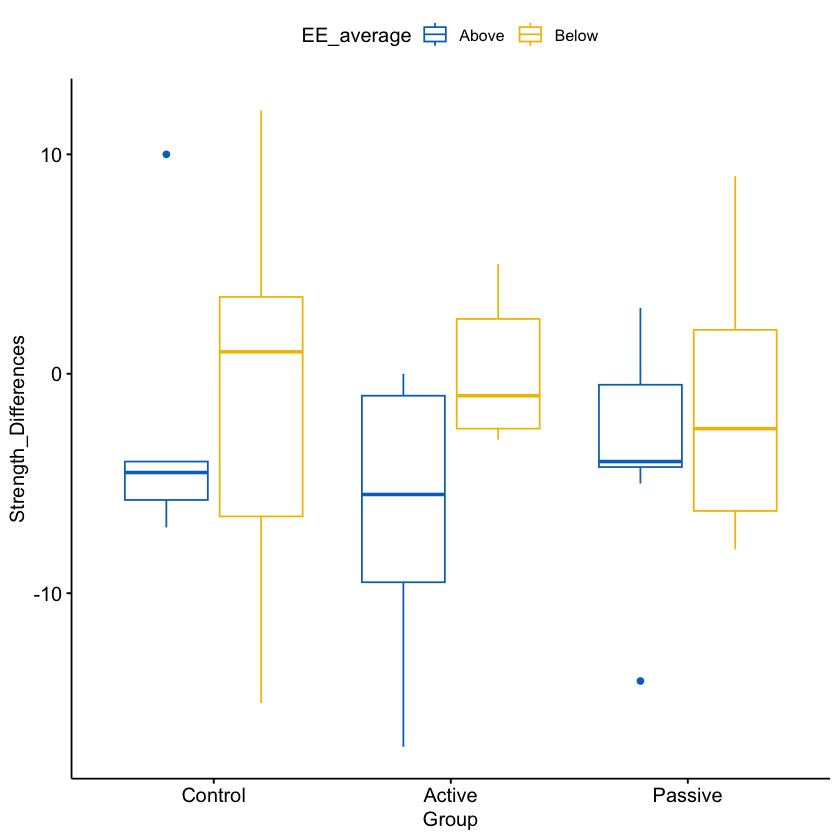

In [49]:
bxp = ggboxplot(Data_f, x = "Group", y = "Strength_Differences", color = "EE_average", palette = "jco")
bxp

Visualization: box plots with p-values

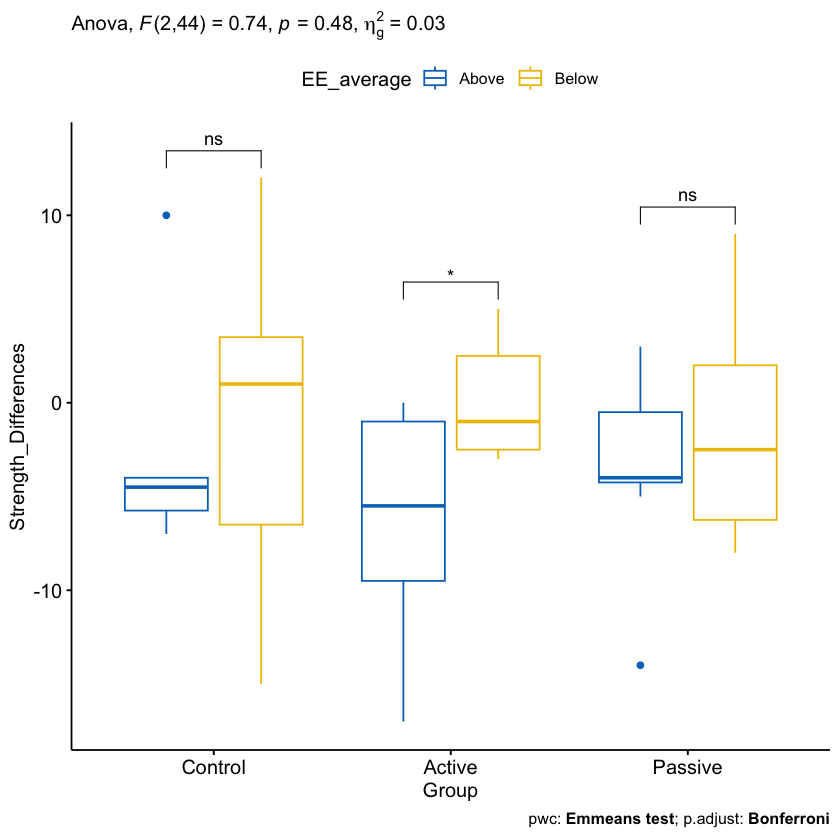

In [50]:
pairwise_t2 = pairwise_t2 %>% add_xy_position(x = "Group")
bxp + 
  stat_pvalue_manual(pairwise_t2) + 
  labs(subtitle = get_test_label(aov_test2, detailed = TRUE), 
       caption = get_pwc_label(pairwise_t2))

**2) Investigating the effect of 'Group' at every level of 'EE_average'**

Analyzing simple main effects - group data by 'EE_average' and fit ANOVA:

In [51]:
Data_f %>% group_by(EE_average) %>% anova_test(Strength_Differences ~ Group, error = model)

,EE_average,Effect,DFn,DFd,F,p,p<.05,ges
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
1,Above,Group,2,44,0.710,0.497,,0.031
2,Below,Group,2,44,0.145,0.865,,0.007


The simple main effect of 'Group' on strength differences in both 'EE_average' groups is not statistically significant.

Pairwise comparison:

In [52]:
pairwise_t4 = Data_f %>% group_by(EE_average) %>% emmeans_test(Strength_Differences ~ Group, 
                                                               p.adjust.method = "bonferroni")
pairwise_t4

,EE_average,term,.y.,group1,group2,df,statistic,p,p.adj,p.adj.signif
,<fct>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,Above,Group,Strength_Differences,Control,Active,44,1.08402580,0.2842578,0.8527733,ns
2,Above,Group,Strength_Differences,Control,Passive,44,0.25158420,0.8025338,1.0000000,ns
3,Above,Group,Strength_Differences,Active,Passive,44,-0.89369659,0.3763466,1.0000000,ns
4,Below,Group,Strength_Differences,Control,Active,44,-0.47736755,0.6354632,1.0000000,ns
5,Below,Group,Strength_Differences,Control,Passive,44,0.03588661,0.9715351,1.0000000,ns
6,Below,Group,Strength_Differences,Active,Passive,44,0.47817547,0.6348927,1.0000000,ns


There are no significant differences among subgroups.

## Visualizing

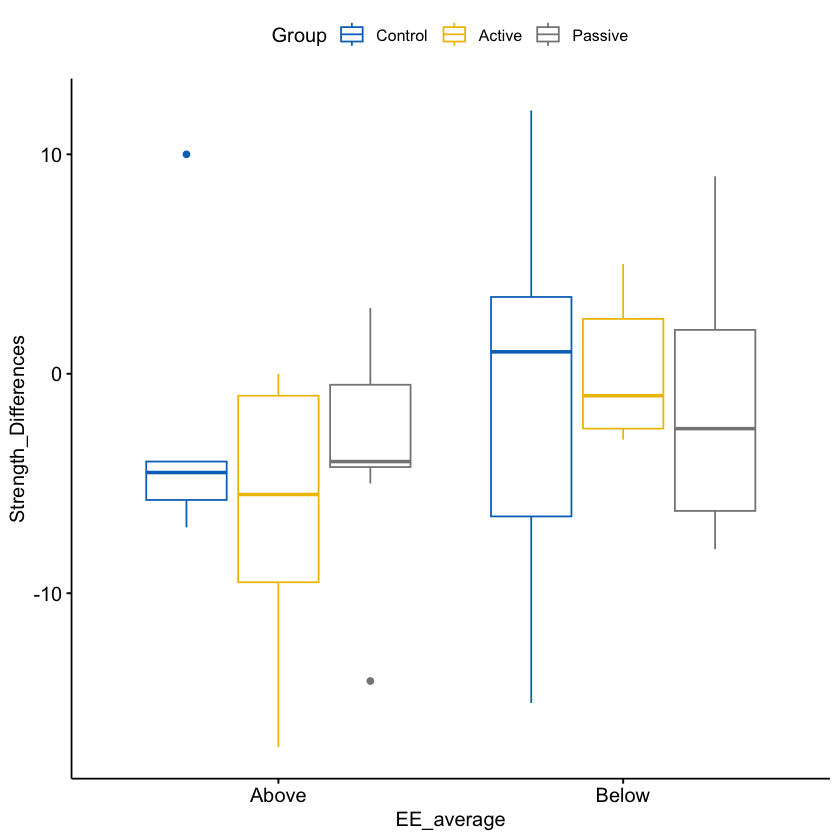

In [53]:
bxp2 = ggboxplot(Data_f, x = "EE_average", y = "Strength_Differences", color = "Group", palette = "jco")
bxp2

Visualization: box plots with p-values

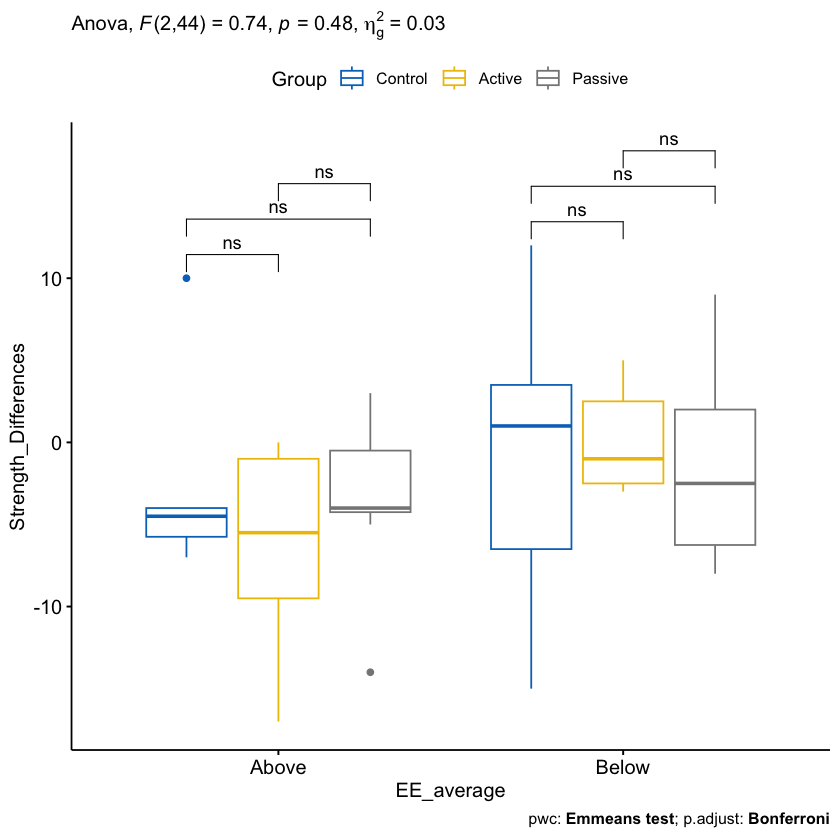

In [54]:
pairwise_t4 = pairwise_t4 %>% add_xy_position(x = "EE_average")
bxp2 + 
  stat_pvalue_manual(pairwise_t4) + 
  labs(subtitle = get_test_label(aov_test2, detailed = TRUE), 
       caption = get_pwc_label(pairwise_t4))

## Conclusion: 

There are significant differences among EE_average groups (above and below), but not among test groups (control, active and passive). Furthermore, when 8 subgroups were analyzed separately, results showed that there are significant differences only among EE_average subgroups in Active test group.